# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

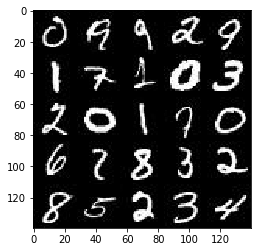

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

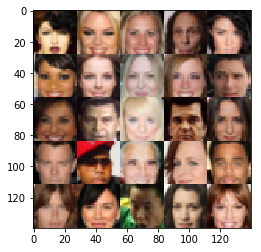

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [19]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
            f1 = 0.5 * (1 + leak)
            f2 = 0.5 * (1 - leak)
            
            return f1 * x + f2 * abs(x)

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 32x32x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 16x16x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 8x8x256

        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x128 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Train
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    class GAN:
        def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
            image_width = real_size[1]
            image_height = real_size[2]
            image_channels = real_size[3]
            self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height,
                                                                             image_channels, z_size)
            
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[3])
            
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

    net = GAN(data_shape, z_dim, learning_rate, alpha=0.2, beta1=beta1)
    
    losses = []
    samples = []
    batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batches += 1
                
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                
                if batches % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses
                    losses.append((train_loss_d, train_loss_g))

                if batches % show_every == 0:
                    gen_samples = sess.run(generator(net.input_z, data_shape[3], is_train=False),
                                   feed_dict={net.input_z: batch_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                    plt.show()

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4906... Generator Loss: 8.3501
Epoch 1/2... Discriminator Loss: 1.8436... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.2039
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.9222
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 1.1746
Epoch 1/2... Discriminator Loss: 1.9829... Generator Loss: 0.3094
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 2.2541
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 2.0958
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 1.8774
Epoch 1/2... Discriminator Loss: 4.9541... Generator Loss: 0.0466


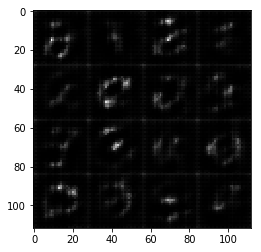

Epoch 1/2... Discriminator Loss: 0.6102... Generator Loss: 1.6427
Epoch 1/2... Discriminator Loss: 0.4732... Generator Loss: 2.2345
Epoch 1/2... Discriminator Loss: 0.3690... Generator Loss: 3.6263
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 2.9957
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 3.2519
Epoch 1/2... Discriminator Loss: 1.6615... Generator Loss: 1.6150
Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 1.9306... Generator Loss: 0.3170
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.6332
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 1.8025


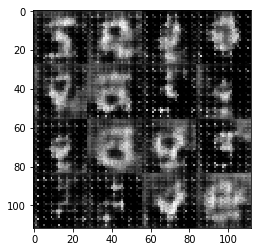

Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 1.8105
Epoch 1/2... Discriminator Loss: 0.4450... Generator Loss: 4.3744
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 5.4283
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 4.0835
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 3.2690
Epoch 1/2... Discriminator Loss: 0.4419... Generator Loss: 3.0556
Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 1.6731
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 3.1171
Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 5.6914
Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 4.2835


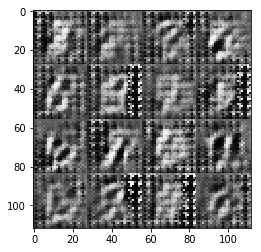

Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 6.2232
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 2.0419
Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 3.2313
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 5.2666
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 3.1960
Epoch 1/2... Discriminator Loss: 0.3927... Generator Loss: 4.1516
Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 7.3168
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 6.2991
Epoch 1/2... Discriminator Loss: 0.4141... Generator Loss: 3.7709
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.9292


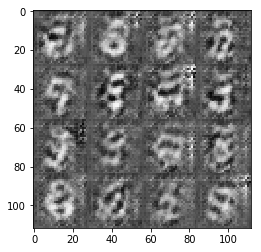

Epoch 1/2... Discriminator Loss: 0.4352... Generator Loss: 3.9453
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 2.1195
Epoch 1/2... Discriminator Loss: 0.3423... Generator Loss: 6.8544
Epoch 1/2... Discriminator Loss: 1.5268... Generator Loss: 0.5224
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.5224
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.7349


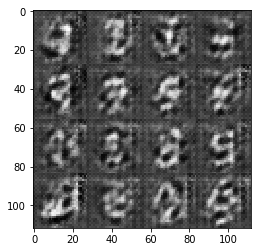

Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 0.9749
Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 2.5945
Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.5568
Epoch 1/2... Discriminator Loss: 1.9596... Generator Loss: 0.2600
Epoch 1/2... Discriminator Loss: 0.8362... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 0.9077... Generator Loss: 1.5684
Epoch 1/2... Discriminator Loss: 1.6980... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.9250
Epoch 1/2... Discriminator Loss: 0.5364... Generator Loss: 3.9639


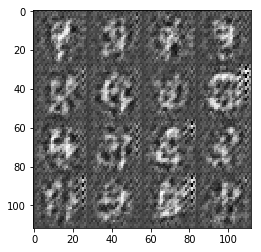

Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 3.1432
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.4408
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 1.4301
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 4.4197
Epoch 1/2... Discriminator Loss: 2.6875... Generator Loss: 0.1276
Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 1.4942
Epoch 1/2... Discriminator Loss: 0.4403... Generator Loss: 2.9432


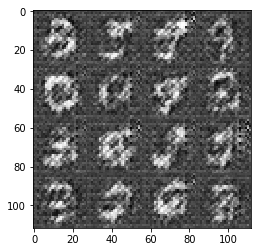

Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.3354
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.6949
Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 3.3898
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 2.3967
Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 3.1662
Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 1.8328
Epoch 1/2... Discriminator Loss: 0.4723... Generator Loss: 2.4532
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 2.1827
Epoch 1/2... Discriminator Loss: 0.3383... Generator Loss: 6.2313
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 4.3584


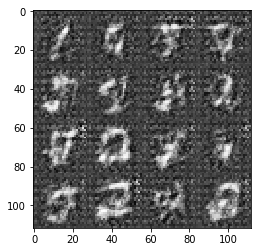

Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 2.1865
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 0.6024... Generator Loss: 1.5954
Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 1.8736
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 2.6808
Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 1.9983
Epoch 1/2... Discriminator Loss: 0.4590... Generator Loss: 2.3569
Epoch 1/2... Discriminator Loss: 3.2607... Generator Loss: 0.1190
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 0.9596


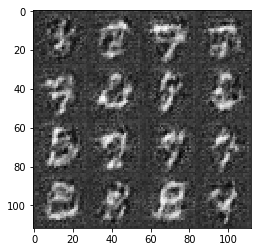

Epoch 1/2... Discriminator Loss: 0.4748... Generator Loss: 2.6887
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.4365
Epoch 1/2... Discriminator Loss: 0.6730... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 1.5171
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.3500
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 0.4290... Generator Loss: 2.6663
Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 4.1847
Epoch 1/2... Discriminator Loss: 0.4987... Generator Loss: 2.0672


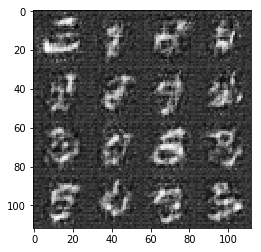

Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 2.3387
Epoch 1/2... Discriminator Loss: 0.5206... Generator Loss: 1.9157
Epoch 1/2... Discriminator Loss: 0.5861... Generator Loss: 1.7096
Epoch 1/2... Discriminator Loss: 0.4508... Generator Loss: 2.6727
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 2.1300
Epoch 1/2... Discriminator Loss: 2.2081... Generator Loss: 0.2393
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 2.1370
Epoch 1/2... Discriminator Loss: 0.5868... Generator Loss: 1.7101
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 2.5377
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 2.3377


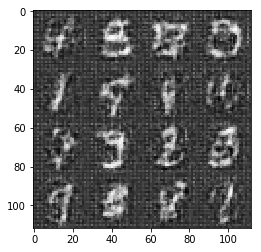

Epoch 1/2... Discriminator Loss: 0.3792... Generator Loss: 3.2854
Epoch 1/2... Discriminator Loss: 0.4822... Generator Loss: 2.2031
Epoch 1/2... Discriminator Loss: 0.4092... Generator Loss: 3.6604
Epoch 1/2... Discriminator Loss: 2.4059... Generator Loss: 3.9866
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.3272
Epoch 1/2... Discriminator Loss: 0.4430... Generator Loss: 2.4069
Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 4.4134
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 4.1837
Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 1.9472
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 3.2457


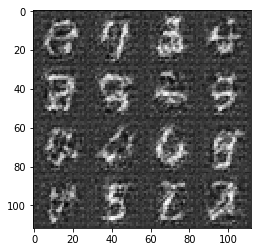

Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 2.2386
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 2.2631
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 2.7362
Epoch 1/2... Discriminator Loss: 0.4574... Generator Loss: 2.3961
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 3.8881
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 2.7162
Epoch 1/2... Discriminator Loss: 0.4003... Generator Loss: 2.9317
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 3.9788
Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 4.4149
Epoch 1/2... Discriminator Loss: 0.3904... Generator Loss: 3.4071


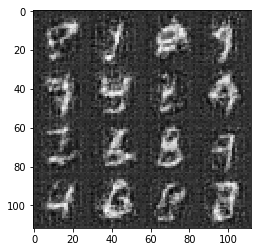

Epoch 1/2... Discriminator Loss: 0.4008... Generator Loss: 4.0557
Epoch 1/2... Discriminator Loss: 0.7349... Generator Loss: 1.3360
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 2.9857
Epoch 1/2... Discriminator Loss: 0.3440... Generator Loss: 4.5537
Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 3.9976
Epoch 1/2... Discriminator Loss: 0.3589... Generator Loss: 3.8841
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 4.2656
Epoch 1/2... Discriminator Loss: 2.0605... Generator Loss: 0.3346
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 1.8244


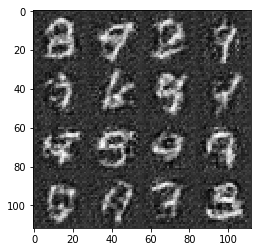

Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 2.7463
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 2.7973
Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 3.1423
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 1.1678
Epoch 1/2... Discriminator Loss: 0.3934... Generator Loss: 3.1423
Epoch 1/2... Discriminator Loss: 0.6859... Generator Loss: 2.0464
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 1.7184
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 3.8742


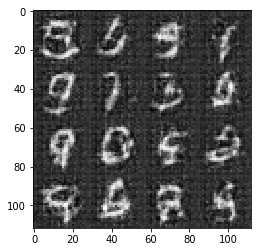

Epoch 1/2... Discriminator Loss: 0.6700... Generator Loss: 2.0127
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 0.4891... Generator Loss: 2.1685
Epoch 1/2... Discriminator Loss: 0.5556... Generator Loss: 1.8589
Epoch 1/2... Discriminator Loss: 2.3435... Generator Loss: 0.2270
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 2.0335
Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 2.1583
Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.3573
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 1.7771


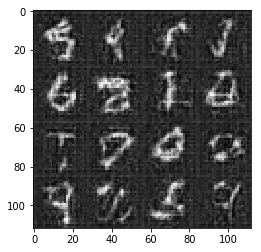

Epoch 1/2... Discriminator Loss: 2.3945... Generator Loss: 0.2202
Epoch 1/2... Discriminator Loss: 0.5141... Generator Loss: 2.2357
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 3.2258
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 3.2799
Epoch 1/2... Discriminator Loss: 0.3811... Generator Loss: 3.1327
Epoch 1/2... Discriminator Loss: 0.3628... Generator Loss: 4.2805
Epoch 1/2... Discriminator Loss: 0.3433... Generator Loss: 4.8095
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 2.6446
Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 5.7375
Epoch 1/2... Discriminator Loss: 0.4419... Generator Loss: 2.4306


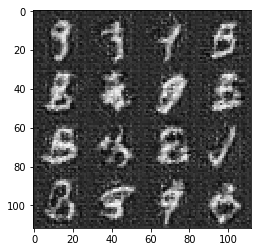

Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 3.8286
Epoch 1/2... Discriminator Loss: 0.3608... Generator Loss: 3.8287
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 4.2383
Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 4.2616
Epoch 1/2... Discriminator Loss: 0.4738... Generator Loss: 2.9618
Epoch 1/2... Discriminator Loss: 2.6956... Generator Loss: 0.2026
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 2.1650
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.3480
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 3.6427
Epoch 1/2... Discriminator Loss: 0.6434... Generator Loss: 1.5314


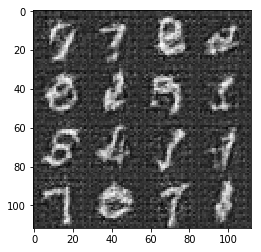

Epoch 1/2... Discriminator Loss: 0.3416... Generator Loss: 5.1206
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.8185
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 2.2560
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 3.8849
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 3.9364
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 2.7865
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 2.7529
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.3191
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.7423
Epoch 2/2... Discriminator Loss: 0.3725... Generator Loss: 3.7066


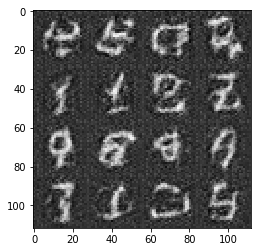

Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 2.0761
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 3.3709
Epoch 2/2... Discriminator Loss: 0.4316... Generator Loss: 2.5330
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 3.0937
Epoch 2/2... Discriminator Loss: 0.5185... Generator Loss: 2.4590
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 0.4713... Generator Loss: 2.5252
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 2.2189
Epoch 2/2... Discriminator Loss: 0.4537... Generator Loss: 2.4632


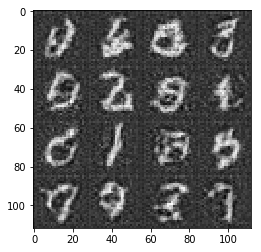

Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 3.4306
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 3.4402
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 4.3628
Epoch 2/2... Discriminator Loss: 0.3545... Generator Loss: 4.1010
Epoch 2/2... Discriminator Loss: 0.3505... Generator Loss: 4.1648
Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 2.8251
Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 2.9592
Epoch 2/2... Discriminator Loss: 0.4090... Generator Loss: 2.8595
Epoch 2/2... Discriminator Loss: 0.3718... Generator Loss: 3.4424
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.1674


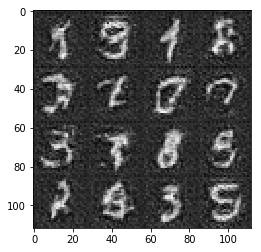

Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 2.7895
Epoch 2/2... Discriminator Loss: 0.4060... Generator Loss: 2.9519
Epoch 2/2... Discriminator Loss: 0.4093... Generator Loss: 2.7481
Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 2.8916
Epoch 2/2... Discriminator Loss: 0.3370... Generator Loss: 5.6423
Epoch 2/2... Discriminator Loss: 0.3479... Generator Loss: 4.4576
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 1.8629
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 2.0529
Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 2.0678


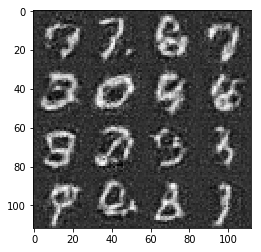

Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 2.6738
Epoch 2/2... Discriminator Loss: 0.4501... Generator Loss: 2.4966
Epoch 2/2... Discriminator Loss: 0.4694... Generator Loss: 2.4053
Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 3.6662
Epoch 2/2... Discriminator Loss: 0.4868... Generator Loss: 2.1733
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 4.9613
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 2.1662
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 2.1765
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 2.8081


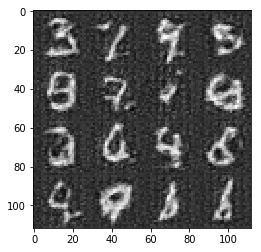

Epoch 2/2... Discriminator Loss: 0.3543... Generator Loss: 5.2811
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 3.7517
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 5.3480
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 3.5182
Epoch 2/2... Discriminator Loss: 0.5690... Generator Loss: 1.9502
Epoch 2/2... Discriminator Loss: 2.5862... Generator Loss: 0.2437
Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 1.6048
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 2.7036
Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 2.4570
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 3.1624


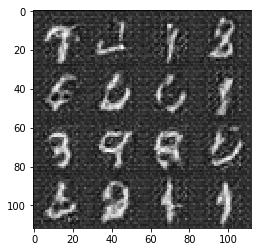

Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 4.6384
Epoch 2/2... Discriminator Loss: 0.8083... Generator Loss: 1.3264
Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 2.2050
Epoch 2/2... Discriminator Loss: 0.3777... Generator Loss: 3.2971
Epoch 2/2... Discriminator Loss: 0.3643... Generator Loss: 3.6034
Epoch 2/2... Discriminator Loss: 0.3603... Generator Loss: 4.1574
Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 5.7863
Epoch 2/2... Discriminator Loss: 0.3835... Generator Loss: 4.9431
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 3.2435
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 2.2982


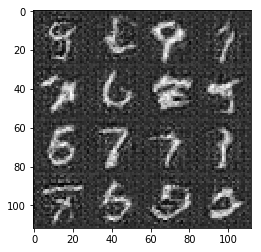

Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 4.4018
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 2.3441
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 4.9516
Epoch 2/2... Discriminator Loss: 0.3812... Generator Loss: 3.3188
Epoch 2/2... Discriminator Loss: 0.4925... Generator Loss: 2.5624
Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 2.0046
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.6091
Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 2.6939
Epoch 2/2... Discriminator Loss: 0.3718... Generator Loss: 4.0266
Epoch 2/2... Discriminator Loss: 0.3723... Generator Loss: 4.5554


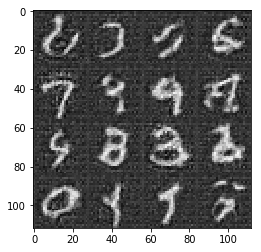

Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 1.8658
Epoch 2/2... Discriminator Loss: 0.3661... Generator Loss: 4.0298
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 2.2347
Epoch 2/2... Discriminator Loss: 0.5361... Generator Loss: 1.9518
Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 5.3798
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.6333
Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 2.7774
Epoch 2/2... Discriminator Loss: 0.5854... Generator Loss: 1.6808
Epoch 2/2... Discriminator Loss: 0.3782... Generator Loss: 4.0121
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 3.3135


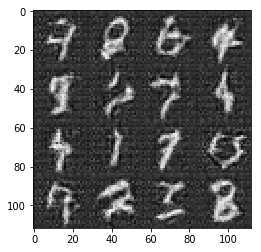

Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 3.7446
Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 3.9665
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 2.3707
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 2.9604
Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 5.7078
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 2.2226
Epoch 2/2... Discriminator Loss: 0.5454... Generator Loss: 1.8754
Epoch 2/2... Discriminator Loss: 0.5707... Generator Loss: 1.7262
Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 2.9862
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 3.3786


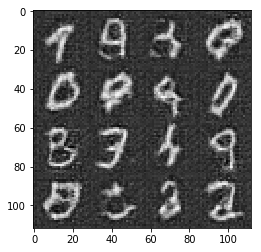

Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.7049
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 2.7512
Epoch 2/2... Discriminator Loss: 0.4006... Generator Loss: 3.1481
Epoch 2/2... Discriminator Loss: 0.5517... Generator Loss: 1.8479
Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 2.9060
Epoch 2/2... Discriminator Loss: 0.3674... Generator Loss: 3.5619
Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 2.9587
Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 4.4800
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 4.2716
Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 3.7165


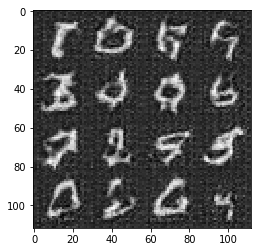

Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 5.0413
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.8521
Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 2.0196
Epoch 2/2... Discriminator Loss: 0.3358... Generator Loss: 5.8005
Epoch 2/2... Discriminator Loss: 0.4303... Generator Loss: 2.7175
Epoch 2/2... Discriminator Loss: 0.3771... Generator Loss: 3.6387
Epoch 2/2... Discriminator Loss: 0.3518... Generator Loss: 4.1530
Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 4.0483
Epoch 2/2... Discriminator Loss: 0.3554... Generator Loss: 4.1805
Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 3.1657


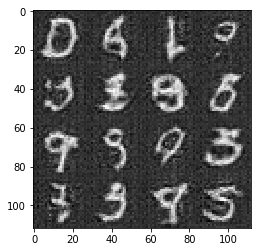

Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 5.2859
Epoch 2/2... Discriminator Loss: 0.3429... Generator Loss: 5.2116
Epoch 2/2... Discriminator Loss: 0.3510... Generator Loss: 4.1981
Epoch 2/2... Discriminator Loss: 0.3443... Generator Loss: 4.8054
Epoch 2/2... Discriminator Loss: 0.4017... Generator Loss: 3.3150
Epoch 2/2... Discriminator Loss: 0.3602... Generator Loss: 3.7834
Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 4.6534
Epoch 2/2... Discriminator Loss: 0.3671... Generator Loss: 3.7672
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 3.6440
Epoch 2/2... Discriminator Loss: 0.3797... Generator Loss: 4.5115


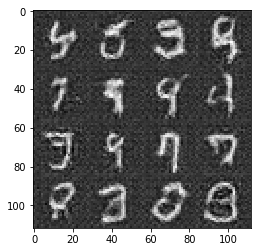

Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 4.1864
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 2.5509
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 3.4715
Epoch 2/2... Discriminator Loss: 0.4182... Generator Loss: 2.8853
Epoch 2/2... Discriminator Loss: 0.5271... Generator Loss: 2.1055
Epoch 2/2... Discriminator Loss: 0.3598... Generator Loss: 3.9701
Epoch 2/2... Discriminator Loss: 0.3507... Generator Loss: 4.4187
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 2.3685
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 2.9772
Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 2.9603


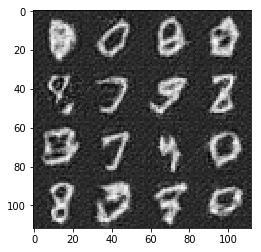

Epoch 2/2... Discriminator Loss: 0.3953... Generator Loss: 2.9882
Epoch 2/2... Discriminator Loss: 0.3703... Generator Loss: 3.6690
Epoch 2/2... Discriminator Loss: 0.3797... Generator Loss: 3.2594
Epoch 2/2... Discriminator Loss: 0.3368... Generator Loss: 5.2401
Epoch 2/2... Discriminator Loss: 0.4485... Generator Loss: 2.6616
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 2.7870
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 2.4738
Epoch 2/2... Discriminator Loss: 2.1577... Generator Loss: 0.3288
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.9557


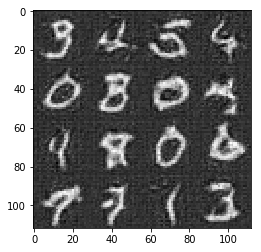

Epoch 2/2... Discriminator Loss: 0.3968... Generator Loss: 3.0631
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 2.6153
Epoch 2/2... Discriminator Loss: 3.0245... Generator Loss: 0.2016
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 3.2126
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 1.6630
Epoch 2/2... Discriminator Loss: 0.4523... Generator Loss: 2.6498
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 2.0149
Epoch 2/2... Discriminator Loss: 0.5546... Generator Loss: 1.9132
Epoch 2/2... Discriminator Loss: 0.3621... Generator Loss: 4.1961
Epoch 2/2... Discriminator Loss: 0.3681... Generator Loss: 3.4102


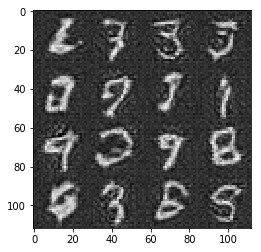

Epoch 2/2... Discriminator Loss: 0.3506... Generator Loss: 4.5723
Epoch 2/2... Discriminator Loss: 0.4497... Generator Loss: 2.4244
Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 5.9940
Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.1790
Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 3.1269
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 2.0503
Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 3.2102
Epoch 2/2... Discriminator Loss: 0.3661... Generator Loss: 3.6493
Epoch 2/2... Discriminator Loss: 2.1784... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.7619


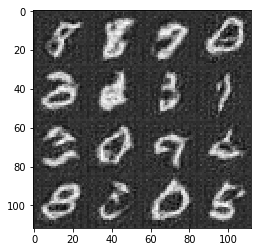

Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 1.6614
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 3.9220
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 2.5416
Epoch 2/2... Discriminator Loss: 0.3900... Generator Loss: 3.4969
Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 4.0905
Epoch 2/2... Discriminator Loss: 0.4808... Generator Loss: 2.2204
Epoch 2/2... Discriminator Loss: 0.4550... Generator Loss: 2.3885
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 2.9917
Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 4.2265
Epoch 2/2... Discriminator Loss: 0.3511... Generator Loss: 4.1097


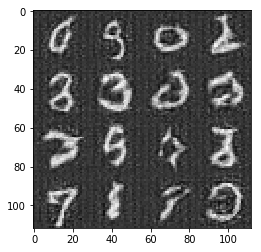

Epoch 2/2... Discriminator Loss: 0.4113... Generator Loss: 2.8167
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.3300
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.7276
Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 2.2009
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 3.7405
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.6316
Epoch 2/2... Discriminator Loss: 0.3929... Generator Loss: 3.3194
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 3.2878
Epoch 2/2... Discriminator Loss: 0.4169... Generator Loss: 2.6648
Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 1.2935


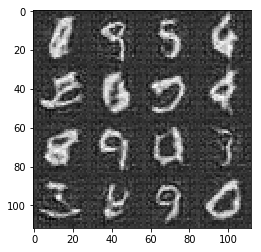

Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 4.8020
Epoch 2/2... Discriminator Loss: 0.3601... Generator Loss: 3.8970
Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 3.2630
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.7590
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.8440


In [33]:
batch_size = 32
z_dim = 100
learning_rate = .001
beta1 = .5
print_every = 10
show_every = 100

import matplotlib.pyplot as plt
import pickle as pkl

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 12.3410
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 4.0842
Epoch 1/1... Discriminator Loss: 3.2201... Generator Loss: 0.2252
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.5936
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 4.7616
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 4.0042
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 2.9265
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 5.8434


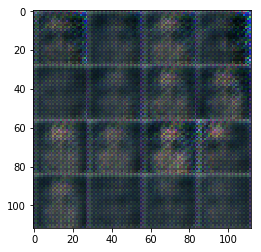

Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 3.6956
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 3.6317
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.2272
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.4475
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.9379
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 2.4894
Epoch 1/1... Discriminator Loss: 3.4498... Generator Loss: 8.3126
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.3176


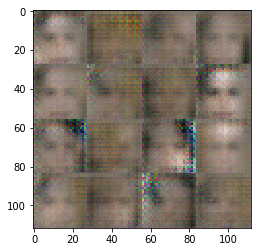

Epoch 1/1... Discriminator Loss: 1.7269... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.9780
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 3.6098
Epoch 1/1... Discriminator Loss: 2.2659... Generator Loss: 0.2295
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.3634
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.9622
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 5.5048
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 1.5728


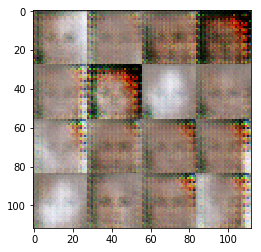

Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 3.3327
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.4414
Epoch 1/1... Discriminator Loss: 3.4719... Generator Loss: 2.8329
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.3924
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 3.5301
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.7148
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.1251
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.9709


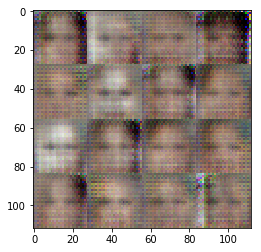

Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.5639
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 3.4427
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.5033


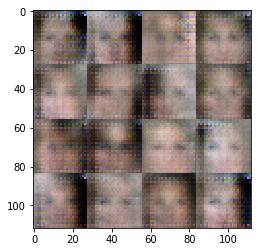

Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 3.0459
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.2755
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.3199
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.8724
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.0348
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 3.9668
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9022


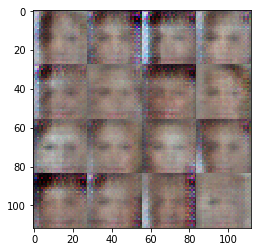

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 2.6131
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 4.1956
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.3057
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.8984... Generator Loss: 3.7361


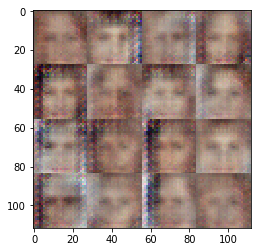

Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 3.9353
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 3.3904
Epoch 1/1... Discriminator Loss: 2.0563... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.3563
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 3.8820
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 4.7476
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 4.3232
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 7.2414
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 4.1095


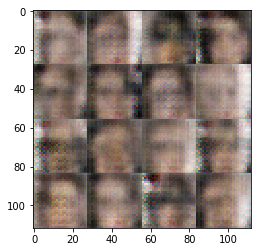

Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 2.9934
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 4.9702
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 4.3535
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.9849... Generator Loss: 0.3569
Epoch 1/1... Discriminator Loss: 1.6464... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 4.1277
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0317


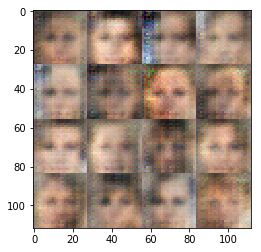

Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 3.4076
Epoch 1/1... Discriminator Loss: 2.2541... Generator Loss: 5.6770
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 3.0290
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.3089
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 3.8525
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 5.7336
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 4.6186
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 4.9183
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 4.9700
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.3640


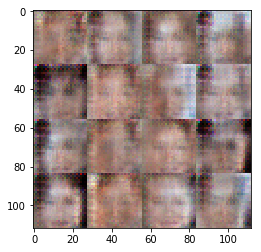

Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 2.1746
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 2.3440
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.4795
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.1632
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 4.7566
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 2.2161
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 3.3475


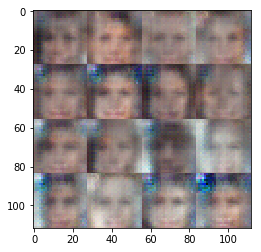

Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 6.8514
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 2.6823
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 6.5177
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 5.0996
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 4.6405
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 3.9893
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 4.8245
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 3.8833
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 3.8793
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.3497


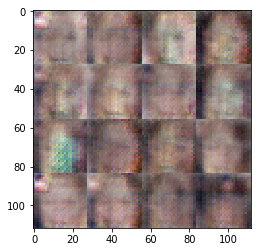

Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 5.5189
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 5.3898
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 6.3416
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 4.8107
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 8.7269
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 5.8390
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 4.4365
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 4.2415
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 2.8589
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 4.2441


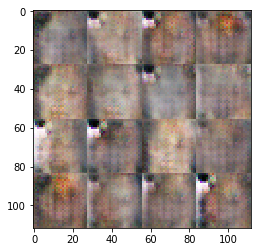

Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 5.6676
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 8.7442
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 4.1168
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 3.4901
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 6.7101
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 5.7686
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 6.2267
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 8.5056
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 3.9297
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 3.0374


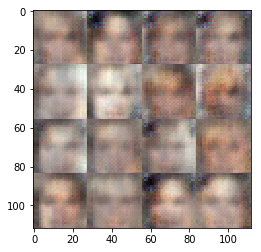

Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.7749
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 4.7943
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 5.8678
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.7259
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 1.6999
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.6135


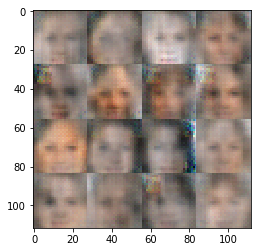

Epoch 1/1... Discriminator Loss: 2.3404... Generator Loss: 0.2028
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.6232


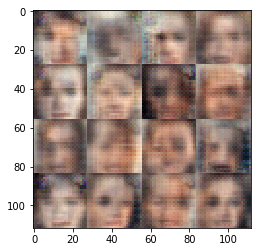

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 2.0382
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.1247
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.4753


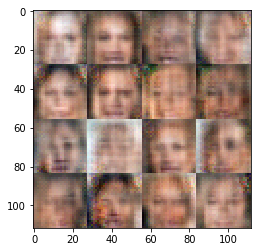

Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.1891


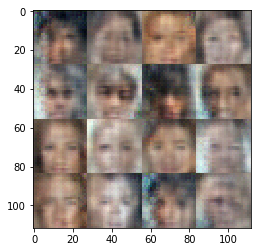

Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 2.3786
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 1.9567
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7705


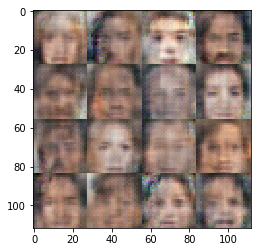

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.2245


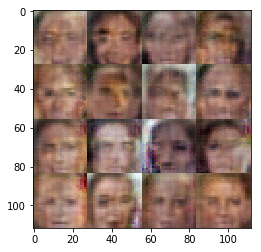

Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.5297
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.5477
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.9458


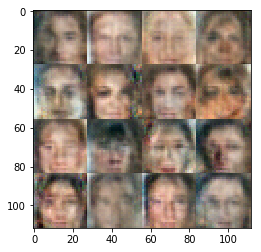

Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.8892
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.6701


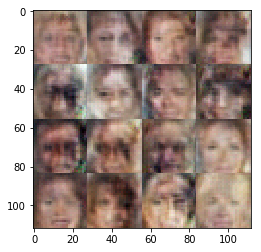

Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 3.9163
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 6.2218
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 3.9563
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 2.7721
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.4593
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 4.3948
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 2.4709
Epoch 1/1... Discriminator Loss: 1.9339... Generator Loss: 3.7344


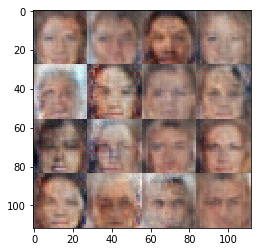

Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 2.2766
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.9188
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 3.7082
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 3.3096
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 1.4706
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 1.6294
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 5.5191
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 3.0919


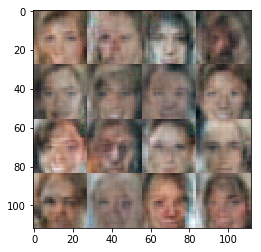

Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 3.6670
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 2.4244
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 2.0482
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 3.0419
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.0052
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.7454


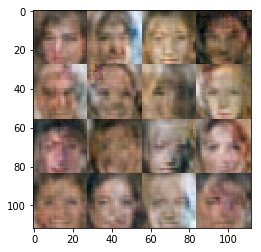

Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 3.1436
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.1378
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 2.5815
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.3474


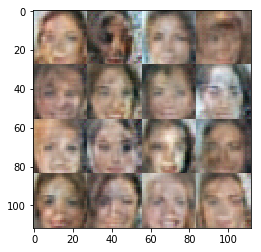

Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 0.6015... Generator Loss: 2.5729
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.2023
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8187


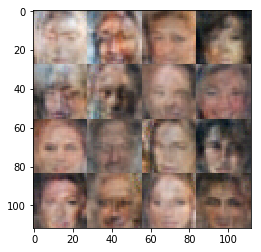

Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 2.5430
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.6891
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 2.1267
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.8056


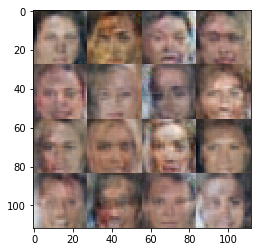

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 2.3473
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 2.4043... Generator Loss: 3.9795


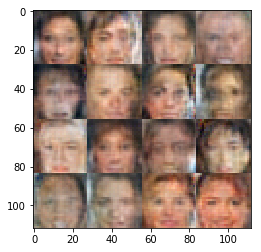

Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.4780
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 3.3204
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 2.8264
Epoch 1/1... Discriminator Loss: 2.4570... Generator Loss: 0.2879


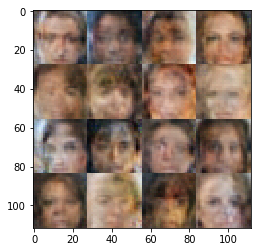

Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.5305
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.0970
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 2.3359
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 2.4439
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.1789


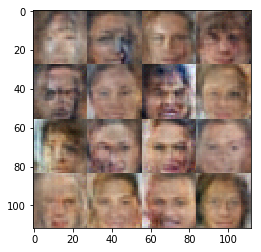

Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.7607... Generator Loss: 3.3186
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.8919
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.6477
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 2.2031... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.2164


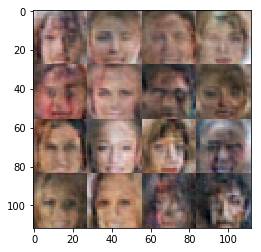

Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.8938


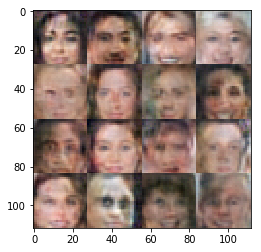

Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.7042... Generator Loss: 2.4636
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.6437


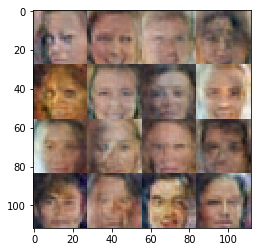

Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.8796... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.7704
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 2.3142... Generator Loss: 0.2206
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.4536


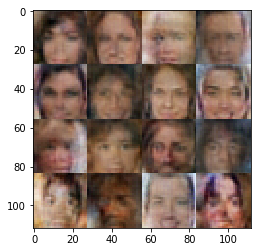

Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.6968
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 2.2946
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 0.3316


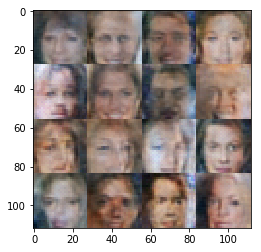

Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 2.0938
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 2.3381... Generator Loss: 0.2138
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.7189


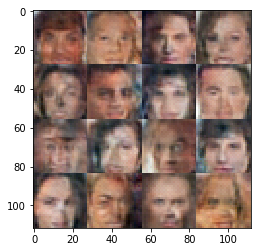

Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.7583
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 2.2155


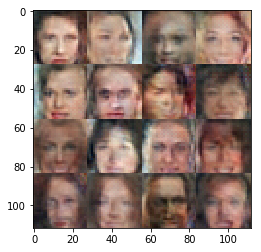

Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.4914
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.8072
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 2.4149
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6031


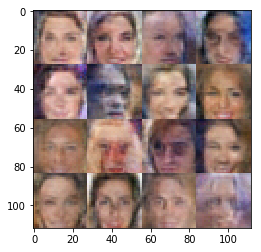

Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.8657
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 2.3308... Generator Loss: 3.5640
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.8484
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.0560


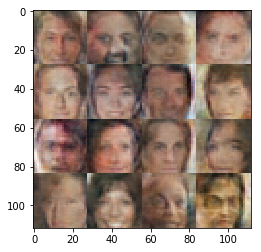

Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 2.4102
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 2.3451
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7359


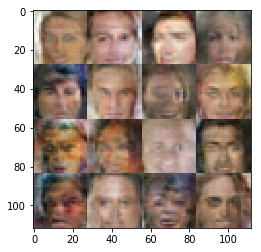

Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.9945
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.4329
Epoch 1/1... Discriminator Loss: 1.7671... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.2314
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.6232


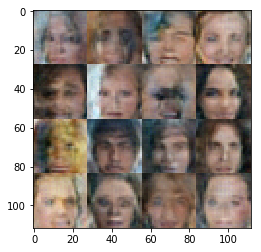

Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.6330
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.2195


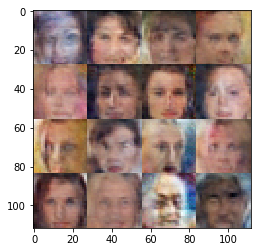

Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.7243... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 2.0829
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.3404


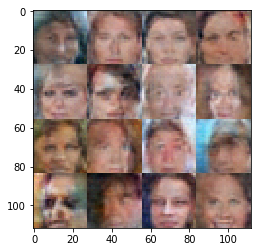

Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.7626... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.0113


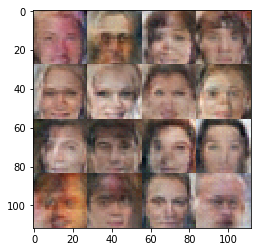

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 1.8514
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 0.9710


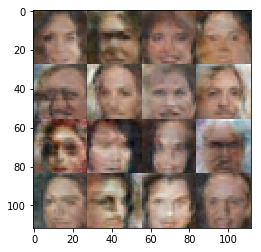

Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 2.5996
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 2.5246
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 2.7633
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 2.9619
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 1.7579
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.6310


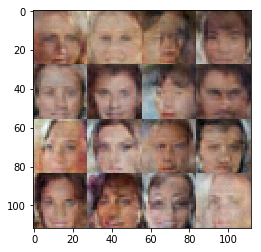

Epoch 1/1... Discriminator Loss: 1.9439... Generator Loss: 0.2817
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.5977
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 2.6382
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 2.8379
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7012


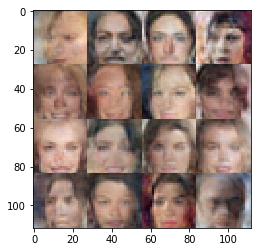

Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.6189
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.5390
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.9976
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 1.1213


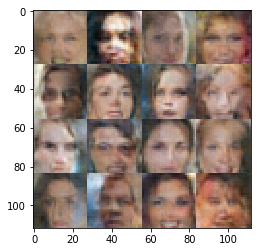

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.5394
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.9357... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.9285


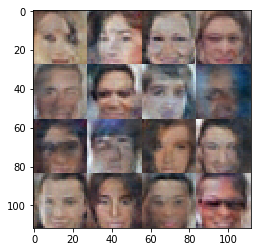

Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 3.5131
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.9041


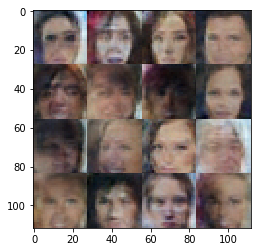

Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.8336
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 1.6025
Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 2.4038
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.0032


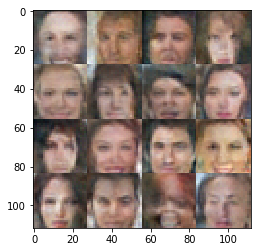

Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.2241
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.6060


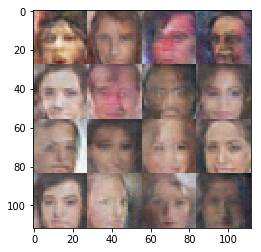

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.6463
Epoch 1/1... Discriminator Loss: 2.0794... Generator Loss: 0.2912
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 2.2287
Epoch 1/1... Discriminator Loss: 1.7464... Generator Loss: 0.3478


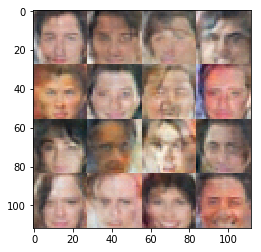

Epoch 1/1... Discriminator Loss: 1.8109... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 2.2002... Generator Loss: 3.0220
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 2.3800
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 1.9957
Epoch 1/1... Discriminator Loss: 1.7994... Generator Loss: 0.3203
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4758


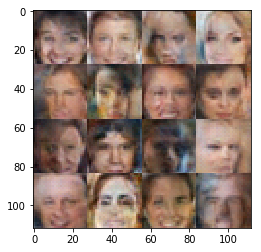

Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.1744
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 2.6880
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 1.8563
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 2.1318
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.2506


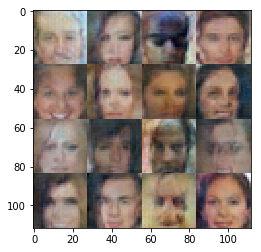

Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.5869
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.6932


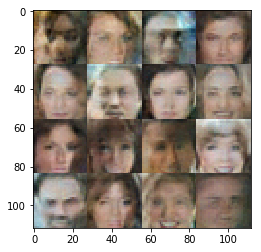

Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.8140
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.5611
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.3914


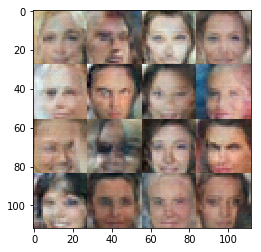

Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 2.1737... Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.1504
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7119


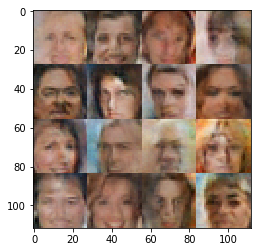

Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 2.0578... Generator Loss: 0.2652
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 2.3636
Epoch 1/1... Discriminator Loss: 2.5184... Generator Loss: 1.9742
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.2234


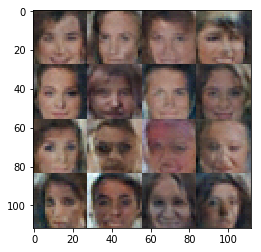

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.7494
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.4917
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 1.6159
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.9697


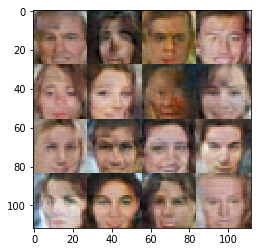

Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.8157
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 1.8241
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.0184


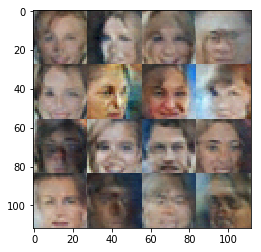

Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 2.2496... Generator Loss: 0.2357
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 3.0092
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 3.1007
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.3174


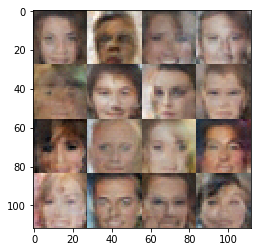

Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6113


In [34]:
batch_size = 32
z_dim = 100
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.